In [406]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings; warnings.filterwarnings('ignore')

%matplotlib inline

## data load

In [407]:
import os

data_path = "../../data/train"


In [408]:
year_data = pd.read_csv(os.path.join(data_path, 'years.tsv'), sep='\t')
writer_data = pd.read_csv(os.path.join(data_path, 'writers.tsv'), sep='\t')
title_data = pd.read_csv(os.path.join(data_path, 'titles.tsv'), sep='\t')
genre_data = pd.read_csv(os.path.join(data_path, 'genres.tsv'), sep='\t')
director_data = pd.read_csv(os.path.join(data_path, 'directors.tsv'), sep='\t')

year_data.shape, writer_data.shape, title_data.shape, genre_data.shape, director_data.shape

((6799, 2), (11306, 2), (6807, 2), (15933, 2), (5905, 2))

## EDA, preprocessing

## side data

**genre_data**

In [409]:
genre_data.head()

,item,genre
0,318,Crime
1,318,Drama
2,2571,Action
3,2571,Sci-Fi
4,2571,Thriller


<Axes: xlabel='genre', ylabel='item'>

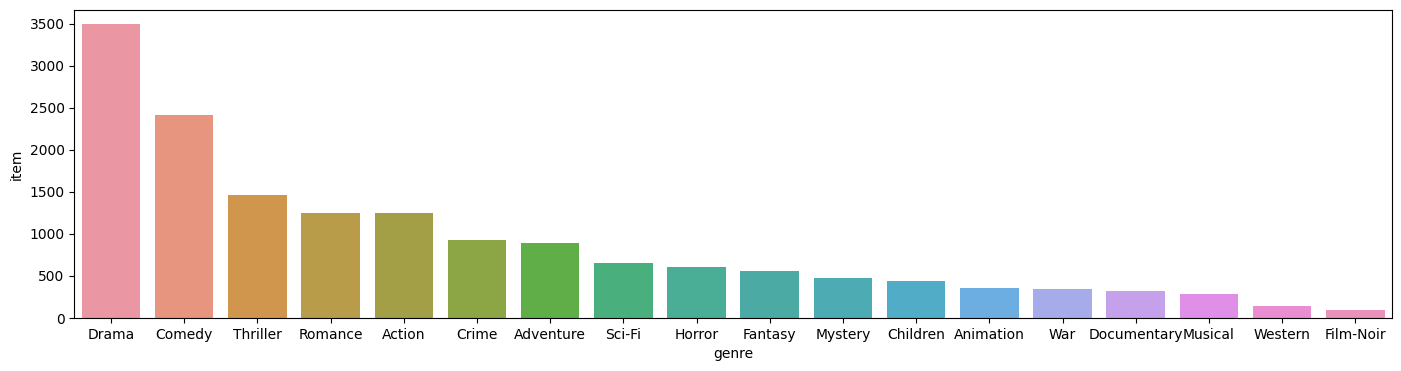

In [410]:
g_genre = genre_data.groupby("genre").count().sort_values(by="item", ascending=False).reset_index()

plt.figure(figsize=(17, 4))
sns.barplot(data=g_genre, x="genre", y="item", ci=None)

**director_data**

In [411]:
director_data.shape

(5905, 2)

In [412]:
director_data["director"].nunique() # 1340

1340

In [413]:
g = director_data.groupby("director").count().sort_values(by="item", ascending=False)
g.describe()

,item
count,1340.00
mean,4.41
std,3.63
min,2.00
25%,2.00
50%,3.00
75%,5.00
max,44.00


In [414]:

# 최고로 많이 찍은 감독이 44편을 찍음.
display(g.head(1))
display(g.tail(1))


,item
director,
nm0000095,44


,item
director,
nm9054338,2


<Axes: ylabel='Density'>

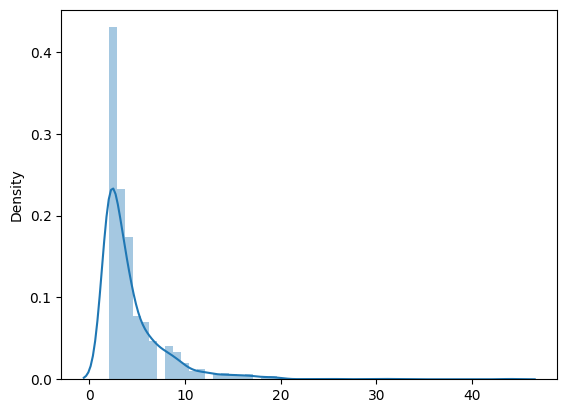

In [415]:
sns.distplot(g, hist=True, kde=True)

**title_data**

In [416]:
title_data.shape

(6807, 2)

In [417]:
title_data["title"].nunique() # ??? 왜 하나 없음

6806

In [418]:
# 이 놈 잡았다.
duplicated_rows = title_data[title_data.duplicated(subset=['title'], keep="first")]
duplicated_rows

,item,title
1926,64997,War of the Worlds (2005)


In [419]:
title_data[title_data["title"] == "War of the Worlds (2005)"]

,item,title
349,34048,War of the Worlds (2005)
1926,64997,War of the Worlds (2005)


In [420]:
dup_title_item = (34048, 64997)

# 그냥 제목만 같고 아예 다른 영화인 듯.
print(ratings_data[ratings_data["item"] == dup_title_item[0]].__len__())
print(ratings_data[ratings_data["item"] == dup_title_item[1]].__len__())

3022
178


**writer_data**

In [421]:
writer_data.shape

(11306, 2)

In [422]:
writer_data.nunique()

item      5648
writer    2989
dtype: int64

In [423]:
g = writer_data.groupby("writer").count().sort_values(by="item", ascending=False)

display(g.head(1))
g.tail(1)

,item
writer,
nm0000095,47


,item
writer,
nm5927608,2


<Axes: ylabel='Density'>

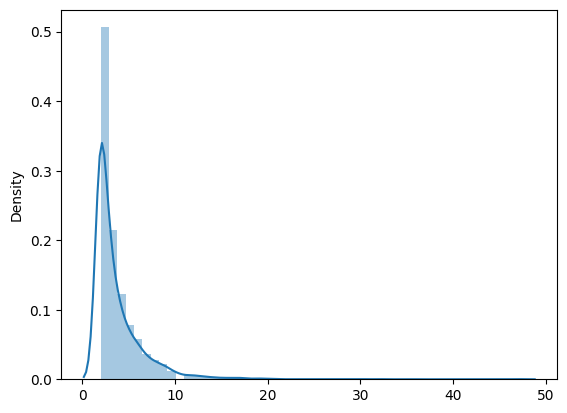

In [424]:
sns.distplot(writer_data.groupby("writer").count(), hist=True, kde=True)

**year_data**

2006


<Axes: xlabel='year', ylabel='item'>

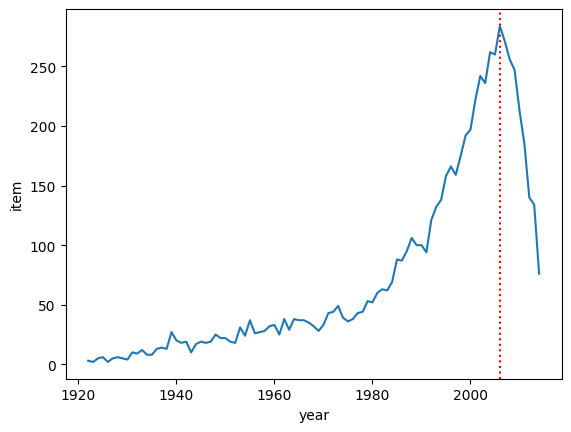

In [425]:
year_g = year_data.groupby("year").count().sort_values(by="item", ascending=False)

max_count = year_g["item"].max()
max_count_year = year_g[year_g["item"] == max_count].index[0]

print(max_count_year)

plt.axvline(max_count_year, color="r", linestyle=":")
sns.lineplot(x=year_g.index, y=year_g["item"])

## main data

In [426]:
ratings_data = pd.read_csv(os.path.join(data_path, "train_ratings.csv"))
ratings_data.shape

(5154471, 3)

**sparsity**

In [427]:
num_train_users = ratings_data['user'].nunique()
num_train_items = ratings_data['item'].nunique()

print("Data sparsity ratio: ", 1 - len(ratings_data) / (num_train_users * num_train_items))

Data sparsity ratio:  0.9758536052697853


**가장 평점 많이(적게) 매겨진 영화는 무엇인가?**

<Axes: xlabel='item', ylabel='Density'>

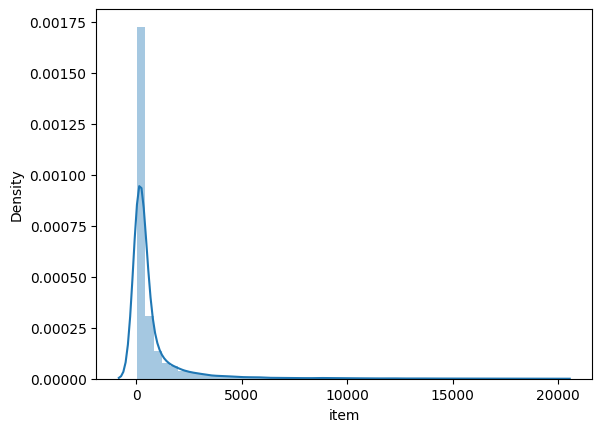

In [428]:
pd.set_option('display.float_format', '{:.2f}'.format)

ratings_data["item"].value_counts()
sns.distplot(ratings_data["item"].value_counts(), hist=True, kde=True)

In [429]:
display(ratings_data["item"].value_counts().head(1))
display(ratings_data["item"].value_counts().tail(1))

2571    19699
Name: item, dtype: int64

51372    27
Name: item, dtype: int64

In [430]:
print(title_data[title_data["item"] == 2571].values)
print(title_data[title_data["item"] == 51372].values)

[[2571 'Matrix, The (1999)']]
[[51372 '"Great Performances" Cats (1998)']]


**추천을 하기에 적합한 리뷰 갯수를 남기긴 했는가?**

In [431]:
ratings_data["user"].value_counts()

8405      2912
54465     1980
24219     1842
32514     1830
91349     1795
          ... 
11211       32
128756      28
105578      22
68606       19
53188       16
Name: user, Length: 31360, dtype: int64

**추천을 남긴 시간대를 어디서부터 어디까지?**

In [432]:
from datetime import datetime

print(datetime.fromtimestamp(ratings_data["time"].max()))
print(datetime.fromtimestamp(ratings_data["time"].min()))

2015-03-31 14:50:52
2005-04-11 20:56:25


**time 변환**

In [433]:
from datetime import datetime

ratings_data["dates"] = ratings_data["time"].apply(lambda unixtime: datetime.fromtimestamp(unixtime))
ratings_data["year"] = ratings_data["dates"].apply(lambda date: date.year)
ratings_data["month"] = ratings_data["dates"].apply(lambda date: date.month)
ratings_data["day"] = ratings_data["dates"].apply(lambda date: date.day)

In [434]:
ratings_data.head(1)

,user,item,time,dates,year,month,day
0,11,4643,1230782529,2009-01-01 13:02:09,2009,1,1


In [435]:
ratings_data.drop(columns=["dates", "time"], inplace=True)

**rating_count 추가**

In [436]:
rating_count_df = pd.DataFrame(ratings_data.groupby("item")["user"].count())

rating_count_df.rename(columns={"user": "rating_count"}, inplace=True)
rating_count_df = rating_count_df.reset_index()

rating_count_df.head(1)

,item,rating_count
0,1,12217


19699
27


<Axes: xlabel='rating_count'>

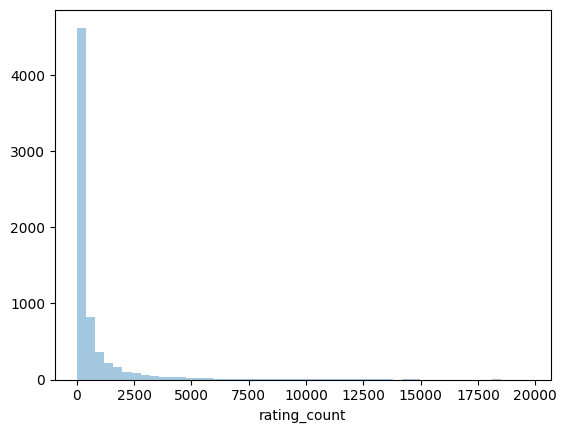

In [437]:
rating_count_df.value_counts(sort=True, ascending=False)

print(rating_count_df["rating_count"].max())
print(rating_count_df["rating_count"].min())

sns.distplot(rating_count_df["rating_count"], hist=True, kde=False)

In [438]:
ratings_data = pd.merge(rating_count_df, ratings_data, on="item", how="inner")
ratings_data.head()

,item,rating_count,user,year,month,day
0,1,12217,11,2009,1,2
1,1,12217,14,2008,10,30
2,1,12217,58,2006,4,3
3,1,12217,82,2011,9,30
4,1,12217,90,2005,9,28


In [439]:
ratings_data.shape

(5154471, 6)

**동일 유저 동일 영화에 여러 평점을 남길 수 있는가?**

In [440]:
# user와 item이 동일한 다른 행이 있는지 확인
duplicates = ratings_data.duplicated(subset=['user', 'item'], keep=False)

# 중복된 행 출력
print(ratings_data[duplicates])

Empty DataFrame
Columns: [item, rating_count, user, year, month, day]
Index: []


In [449]:
# 한 아이템 내 유저가 중복으로 평가하지 않았다는 보장.
assert len(ratings_data[ratings_data["item"] == 1]) == ratings_data[ratings_data["item"] == 1]["user"].nunique()

## merging

- inner join 후 데이터가 약 5154471 -> 46636737로 줄어듦. 

In [441]:
year_data.rename(columns={"year": "open_year"}, inplace=True)

In [442]:
merged_df = pd.merge(ratings_data, director_data, on=['item'], how="inner")
merged_df = pd.merge(merged_df, genre_data, on=['item'], how="inner")
merged_df = pd.merge(merged_df, title_data, on=['item'], how="inner")
merged_df = pd.merge(merged_df, writer_data, on=['item'], how="inner")
merged_df = pd.merge(merged_df, year_data, on=['item'], how="inner")

In [443]:
merged_df.head(1)

,item,rating_count,user,year,month,day,director,genre,title,writer,open_year
0,1,12217,11,2009,1,2,nm0005124,Adventure,Toy Story (1995),nm0004056,1995


## EDA

**유저간 장르 취향 차이가 클까?**

In [532]:
import random

random_user_ids = random.choices(merged_df.value_counts('user').index.to_list(), k=5)

random_user_ids

[87738, 45957, 48876, 29540, 17150]

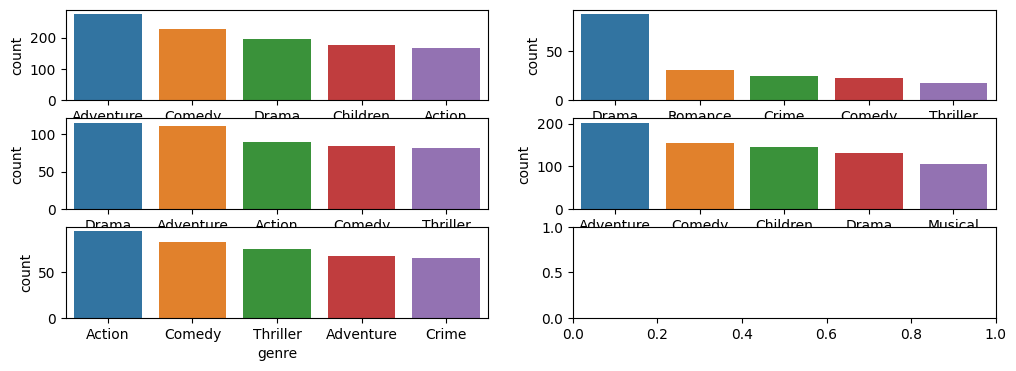

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

In [534]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 4))
axes = axes.flatten()
for i, user_id in enumerate(random_user_ids):
    group_cnt_by_user = merged_df[merged_df["user"] == user_id]  \
    .groupby("genre")["user"].count()   \
    .reset_index().sort_values(by="user", ascending=False)

    group_cnt_by_user.rename(columns={"user": "count"}, inplace=True)

    plt.figure(figsize=(20, 10))
    sns.barplot(data=pd.DataFrame(group_cnt_by_user)[:5], x="genre", y="count", ax=axes[i])
    
plt.tight_layout()


**많이 찍은 감독의 평균 영화 rating count은 높을까?**

- 1편 찍고 시장에서 버려진 감독이 많음.

In [545]:
top_director = director_data.value_counts("director").head().index.to_list()
bottom_director = director_data.value_counts("director").tail().index.to_list()

top_director, bottom_director

(['nm0000095', 'nm0000033', 'nm0000142', 'nm0000229', 'nm0000217'],
 ['nm0404606', 'nm0405605', 'nm0410139', 'nm0410769', 'nm9054338'])

In [553]:
merged_df[merged_df["director"] == top_director[0]]["user"].count()

top_director_cnt = [(merged_df[merged_df["director"] == director]["user"].count()) for director in top_director]
bottom_director_cnt = [(merged_df[merged_df["director"] == director]["user"].count()) for director in bottom_director]

In [558]:
top_director_cnt, bottom_director_cnt

([76313, 288283, 127382, 807463, 246902], [3426, 261, 1117, 1158, 4790])

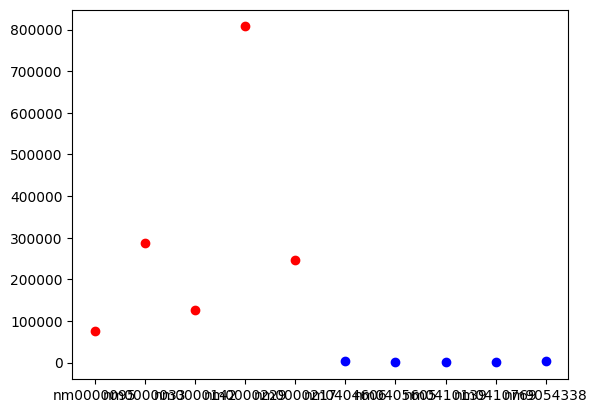

In [556]:
plt.scatter(top_director, top_director_cnt, color="r")
plt.scatter(bottom_director, bottom_director_cnt, color="b")

**많이 쓴 작가의 평균 영화 rating count은 높을까?**

In [560]:
top_writer = writer_data.value_counts("writer").head().index.to_list()
bottom_writer = writer_data.value_counts("writer").tail().index.to_list()

top_writer, bottom_writer

(['nm0000095', 'nm0000636', 'nm0000175', 'nm0372942', 'nm0000108'],
 ['nm0414893', 'nm0414448', 'nm0414117', 'nm0414047', 'nm5927608'])

In [562]:
merged_df[merged_df["writer"] == top_writer[0]]["user"].count()

top_writer_cnt = [(merged_df[merged_df["writer"] == writer]["user"].count()) for writer in top_writer]
bottom_writer_cnt = [(merged_df[merged_df["writer"] == writer]["user"].count()) for writer in bottom_writer]

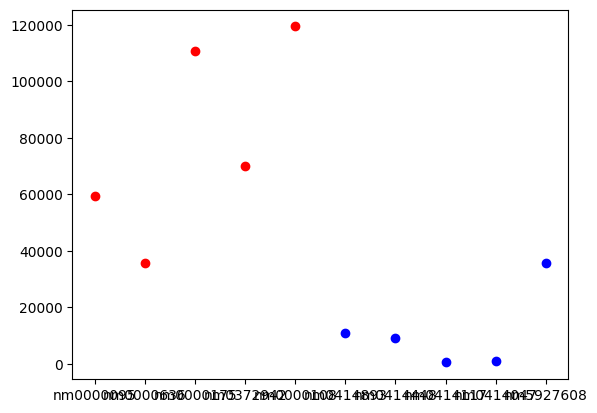

In [563]:
plt.scatter(top_writer, top_writer_cnt, color="r")
plt.scatter(bottom_writer, bottom_writer_cnt, color="b")

**유명한 영화들을 만든 감독과 작가들은 폼이 계속 좋을까?**

In [595]:
# 우선 평균이 어느 정도인데

mean_writer_cnt = merged_df.groupby("writer").count()["user"].mean()
mean_director_cnt = merged_df.groupby("director").count()["user"].mean()

median_writer_cnt = merged_df.groupby("writer").count()["user"].median()
median_director_cnt = merged_df.groupby("director").count()["user"].median()

In [596]:
np.round([mean_writer_cnt, mean_director_cnt, median_writer_cnt, median_director_cnt])

array([15977., 35847.,  3455.,  4620.])

In [567]:
popular_movie_ids = merged_df.value_counts("item").head(10).index.to_list()
popular_movie_ids

[364, 8360, 919, 4306, 588, 1282, 4886, 595, 596, 3114]

In [579]:
best_director_ratings_cnt = []
best_writer_ratings_cnt = []

for popular_movie_id in popular_movie_ids:
    director, writer = merged_df[merged_df["item"] == popular_movie_id].head(1)[["director", "writer"]].values[0]
    
    director_cnt = merged_df[merged_df["director"] == director]["user"].count()
    writer_cnt = merged_df[merged_df["writer"] == writer]["user"].count()
    
    best_director_ratings_cnt.append(director_cnt)
    best_writer_ratings_cnt.append(writer_cnt)

In [581]:
best_director_ratings_cnt

[1009416,
 1214550,
 318317,
 1214550,
 847214,
 170232,
 404142,
 428644,
 250652,
 722144]

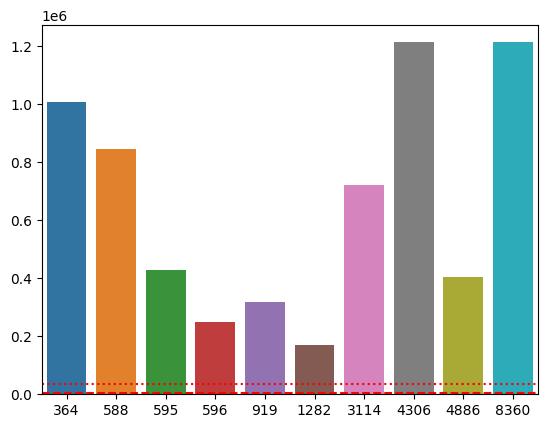

In [600]:
sns.barplot(x=popular_movie_ids, y=best_director_ratings_cnt)
plt.axhline(mean_director_cnt, color="r", linestyle=":")
plt.axhline(median_director_cnt, color="r", linestyle="--")

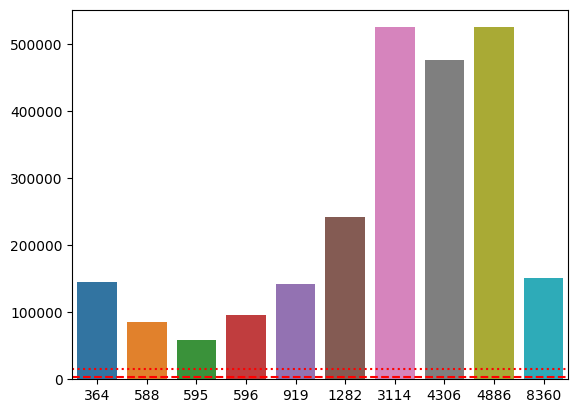

In [601]:
sns.barplot(x=popular_movie_ids, y=best_writer_ratings_cnt)
plt.axhline(mean_writer_cnt, color="r", linestyle=":")
plt.axhline(median_writer_cnt, color="r", linestyle="--")

**영화를 많이 본 유저들은 영화를 선별하는 감식안이 있을까? 아님 걍 보는 것일까**

In [606]:
heavy_user_ids = merged_df["user"].value_counts().head().values
light_user_ids = merged_df["user"].value_counts().tail().values

heavy_user_ids, light_user_ids

(array([15963, 15637, 14483, 12735, 11872]), array([105, 101,  88,  73,  67]))

In [607]:
heavy_user_id = heavy_user_ids[0]

heavy_user_id

15963

## 팀원 EDA 요약

- 영화당 장르가 여러개다
- 영화에 director는 >= 0이다. (없거나, 하나이거나, 다수인 경우 존재)
- 영화에 writer는 >= 0이다. (없거나, 하나이거나, 다수인 경우 존재)

- 궁금증... writer가 없는 영화는 어떻게 처리할 것인가? -> 감독이 writer 역할도 할 수 있을까??
  - 익명화가 되었다고 하니 감독과 작가가 같다고 가정하지는 말자.

- sample_submission는 그냥 popular 10개 넣은 거임. 진짜로 eval할 때 쓸만한 건 아님
- 뭐가 없나..

- 추천이라는 측면에서 상식적으론 가장 많이 본 영화 추천해주면 됨.
- 개인화 특성을 좀 반영하고 싶다.. 특정 유저가 많이 본 장르의 영화 추천
- '점수'가 없다.(implicit data) 점수와 상관 없이 일단 보게끔 만드는게 목적인가? CTR 늘리는 거?